# Exploratory Data Analysis (continued)

In [1]:
from icepyx import icesat2data as ipd
import os
import shutil
from pathlib import Path
import h5py
import pandas as pd
import random
import seaborn as sns

%pylab inline

# Fixing figure output for all figures
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['legend.fontsize'] = 9
rcParams['figure.dpi'] = 150
rcParams['savefig.dpi'] = 200

from utils_atl03 import *

Populating the interactive namespace from numpy and matplotlib


/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Load the ATL06+VIIRS dataframe. 

In [2]:
atl6 = pd.read_csv("dataframe20200702_deltatime")

In [3]:
atl6.head()

,Unnamed: 0,ground_track,t_year,lat,lon,Integer_Cloud_Mask,VIIRS_offset,h_li,s_li,q_flag,...,cloud_flg_atm,msw_flag,fbsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,segment_id,w_surface_window_final
0,0,gt1l,2019-06-01 20:04:48.205868,68.079999,-47.455941,NaN,NaN,1681.1671,0.008938,0,...,0,0,3.402824e+38,3.402824e+38,0,7417902.0,2635365.8,507,623016,3.0
1,1,gt1l,2019-06-01 20:04:48.208686,68.079821,-47.455997,NaN,NaN,1681.0332,0.012630,0,...,0,0,3.402824e+38,3.402824e+38,0,7494146.0,2635369.5,531,623017,3.0
2,2,gt1l,2019-06-01 20:04:48.211507,68.079643,-47.456053,NaN,NaN,1680.8826,0.011899,0,...,0,0,3.402824e+38,3.402824e+38,0,7561520.0,2635373.5,525,623018,3.0
3,3,gt1l,2019-06-01 20:04:48.214329,68.079464,-47.456110,NaN,NaN,1680.7661,0.011329,0,...,0,0,3.402824e+38,3.402824e+38,0,7556358.0,2635377.8,481,623019,3.0
4,4,gt1l,2019-06-01 20:04:48.217151,68.079286,-47.456168,NaN,NaN,1680.6771,0.011673,0,...,0,0,3.402824e+38,3.402824e+38,0,7567084.0,2635381.5,500,623020,3.0


In [4]:
atl6.columns

Index(['Unnamed: 0', 'ground_track', 't_year', 'lat', 'lon',
       'Integer_Cloud_Mask', 'VIIRS_offset', 'h_li', 's_li', 'q_flag', 's_fg',
       'snr', 'h_rb', 'dh_fit_dx', 'bsnow_conf', 'cloud_flg_asr',
       'cloud_flg_atm', 'msw_flag', 'fbsnow_h', 'bsnow_od', 'layer_flag',
       'bckgrd', 'e_bckgrd', 'n_fit_photons', 'segment_id',
       'w_surface_window_final'],
      dtype='object')

### 1) Preliminary observations on VIIRS integration

__NOTE__: A lot of missing `Integer_Cloud_Mask`.

In [5]:
missing_mask = round(atl6.Integer_Cloud_Mask.isnull().sum()/atl6.shape[0]*100)
print('About %d%% of data do not have a VIIRS match.' % missing_mask)

About 63% of data do not have a VIIRS match.


We could include cloud masks from other reliable satellites to try reduce this high level of missingness (probably due to the fact that in many cases the time difference between data from VIIRS and ICESat2 is non-negligible). 

For now, I focus only on data with VIIRS match.

In [6]:
atl6.rename(columns={'Unnamed: 0':'id'}, inplace=True)
atl6 = atl6.set_index("id")
atl6 = atl6[ ~ atl6.Integer_Cloud_Mask.isnull()]
atl6.head()

,ground_track,t_year,lat,lon,Integer_Cloud_Mask,VIIRS_offset,h_li,s_li,q_flag,s_fg,...,cloud_flg_atm,msw_flag,fbsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,segment_id,w_surface_window_final
id,,,,,,,,,,,,,,,,,,,,,
169863,gt1l,2019-06-05 07:10:03.697914,65.730046,-45.782582,3.0,43.933333,2392.4720,0.010225,0,0,...,1,4,3.402824e+38,3.402824e+38,0,2405221.5,778052.30,511,365631,3.0
169864,gt1l,2019-06-05 07:10:03.700749,65.730225,-45.782631,3.0,43.933333,2392.3313,0.010640,0,0,...,1,4,3.402824e+38,3.402824e+38,0,2373940.0,778062.90,492,365632,3.0
169865,gt1l,2019-06-05 07:10:03.703578,65.730403,-45.782680,3.0,43.933333,2392.2230,0.010195,0,0,...,1,4,3.402824e+38,3.402824e+38,0,2310990.5,778072.56,484,365633,3.0
169866,gt1l,2019-06-05 07:10:03.706398,65.730581,-45.782729,3.0,43.933333,2392.1213,0.010343,0,0,...,1,4,3.402824e+38,3.402824e+38,0,2313388.5,778082.25,491,365634,3.0
169867,gt1l,2019-06-05 07:10:03.709218,65.730760,-45.782778,3.0,43.933333,2392.0256,0.010727,0,0,...,1,4,3.402824e+38,3.402824e+38,0,2346084.0,778092.80,524,365635,3.0


The variable `VIIRS_offset` describes the time difference in minutes between VIIRS and ICESat2 data. We can see that in our dataframe such variable only takes values about -20 or sligthly above 40. This can be an issue for cloud mask accuracy.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f735a9a6450>]],
      dtype=object)

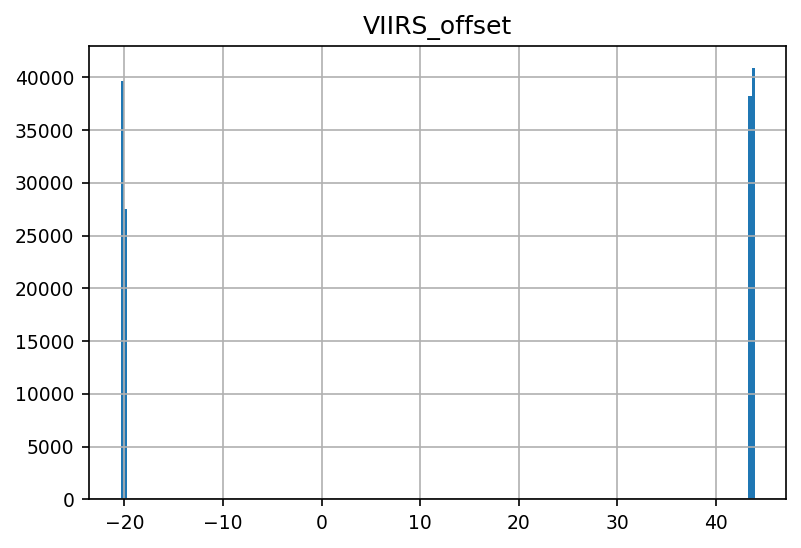

In [7]:
time_diff=atl6.groupby('VIIRS_offset').size()
atl6.hist('VIIRS_offset',bins=200)

### 2) Exploring relation between `Integer_Cloud_Mask` and `cloud_flg_asr`

Using the graphical model with this dataframe, we obtain the following output.

(-0.5, 575.5, 575.5, -0.5)

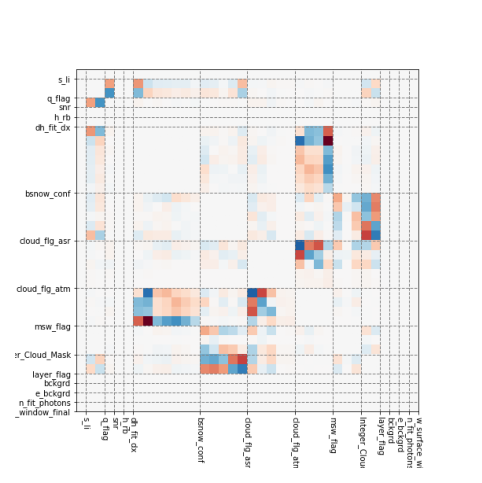

In [9]:
graphical_model=plt.imread('output_graph.png')
plt.figure()
plt.imshow(graphical_model)
plt.axis('off')

First, let's focus on the relation between `Integer_Cloud_Mask` and ATL06 flags. The strongest relation is with `cloud_flg_asr`. Note that:
* The middle row in this cell, corresponding to `Integer_Cloud_Mask` = 1, is greysh probably because we have really few observations with this label.
* In general, the relation does not seem really strong, probably because of the non-negligible `VIIRS_offset` values.
* The colours in the cell make sense:
    * `Integer_Cloud_Mask` = 3 (clear) is positively correlated with small values of `cloud_flg_asr` (clear) and negatively correlated with large values of `cloud_flg_asr` (cloudy).
    * `Integer_Cloud_Mask` = 0 (cloudy) is negatively correlated with small values of `cloud_flg_asr` (clear) and positively correlated with large values of `cloud_flg_asr` (cloudy).

Let's explore more on the relation between `Integer_Cloud_Mask` and `cloud_flg_asr`. In the following plot we observe the histogram of `cloud_flg_asr` values grouped by `Integer_Cloud_Mask`. There is a meaningful connection between cloudy sky label in VIIRS (0.0) and in ATL06 (5), and between clear sky label in VIIRS (3.0) and in ATL06 (1, 2). There are some results that are counterintuitive but they can be partly due to the time mismatch between VIIRS and ATL06, and partly to possible wrong catches of `cloud_flg_asr` that labels as clouds other anomalies.

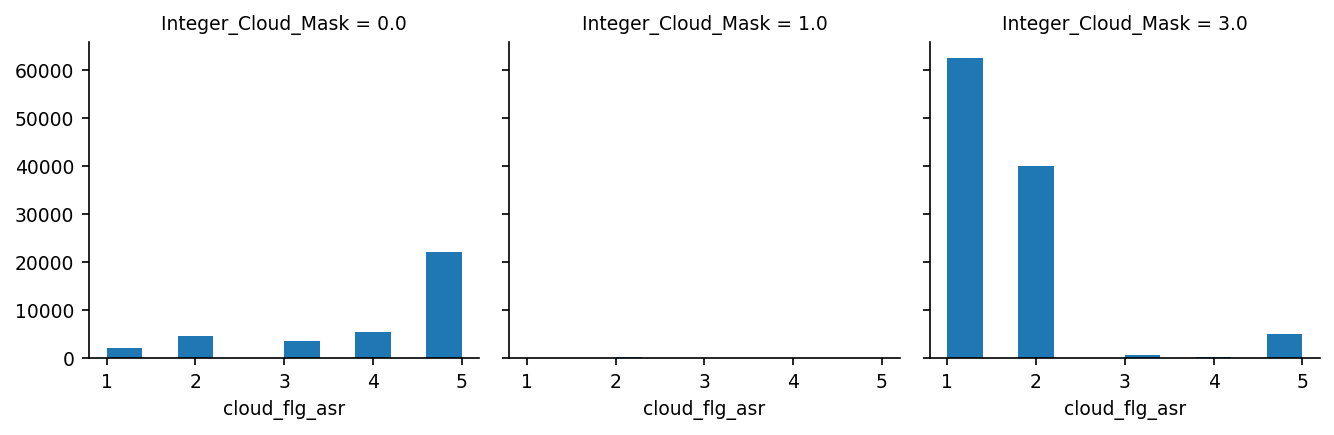

In [10]:
g = sns.FacetGrid(atl6, col="Integer_Cloud_Mask")
g.map(plt.hist, "cloud_flg_asr")

In [11]:
atl6.groupby(['Integer_Cloud_Mask','cloud_flg_asr']).size()

Integer_Cloud_Mask  cloud_flg_asr
0.0                 1                 2015
                    2                 4576
                    3                 3474
                    4                 5340
                    5                22098
1.0                 2                  189
                    5                    3
3.0                 1                62652
                    2                39941
                    3                  722
                    4                  304
                    5                 4937
dtype: int64

Let's look at the spatial distribution of the cloud labels for `Integer_Cloud_Mask` and `cloud_flg_asr`. The eastern area seems to be mostly clear and it correspond to the data with `VIIRS_offset` of about 40 minutes.

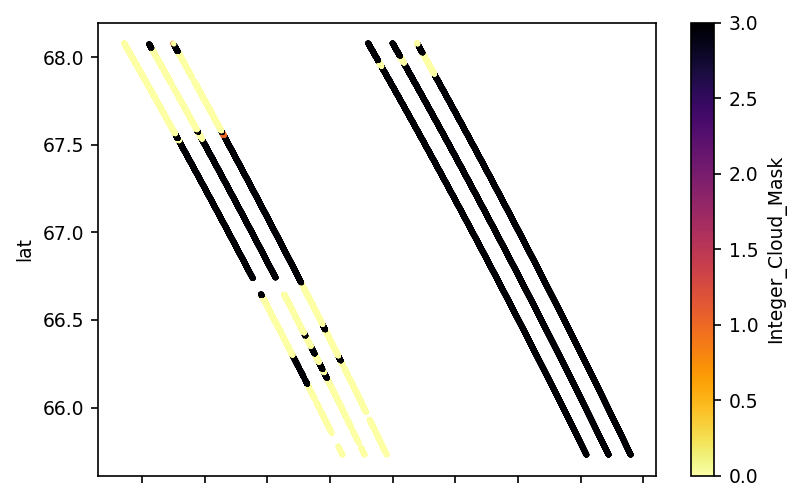

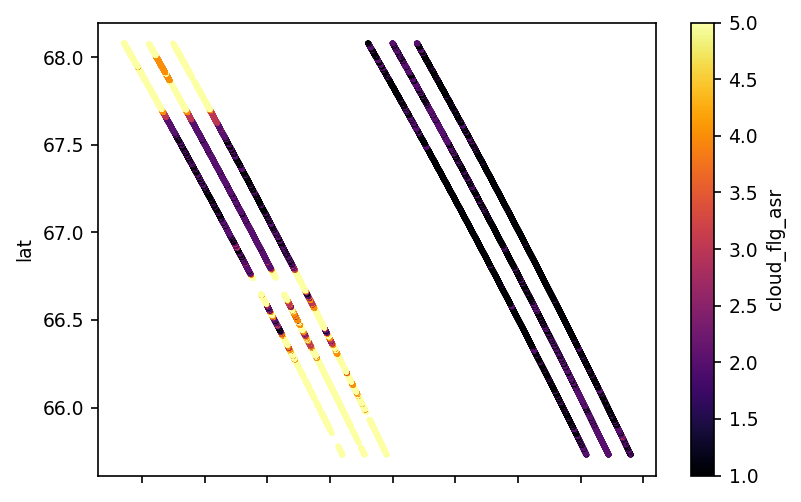

In [12]:
ax1 = atl6.plot.scatter(x='lon', y='lat', c='Integer_Cloud_Mask', s = 2,  colormap='inferno_r')
ax2 = atl6.plot.scatter(x='lon', y='lat', c='cloud_flg_asr', s = 2,  colormap='inferno')

Let's just consider the western part, where VIIRS data are 20 minutes earlier than ATL06 data. From the scatterplot, it seems like the top cloud in the VIIRS image moved a bit northwise in the 20-minute time gap, whereas what is going on in the bottom part is more complicated to understand.

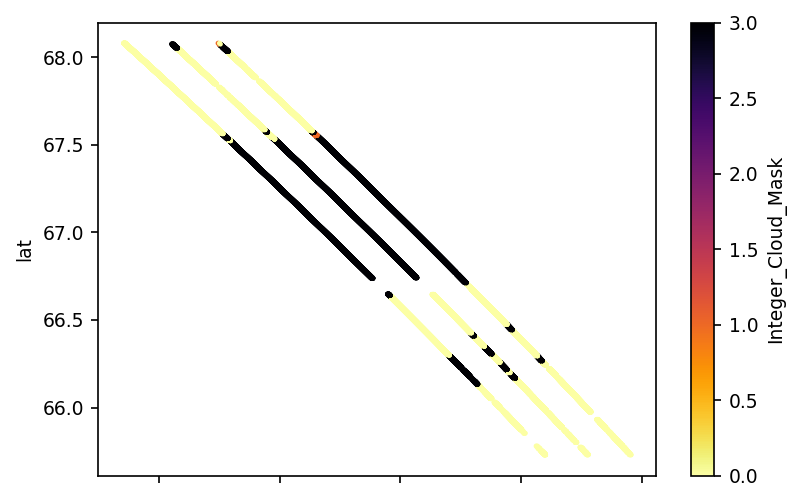

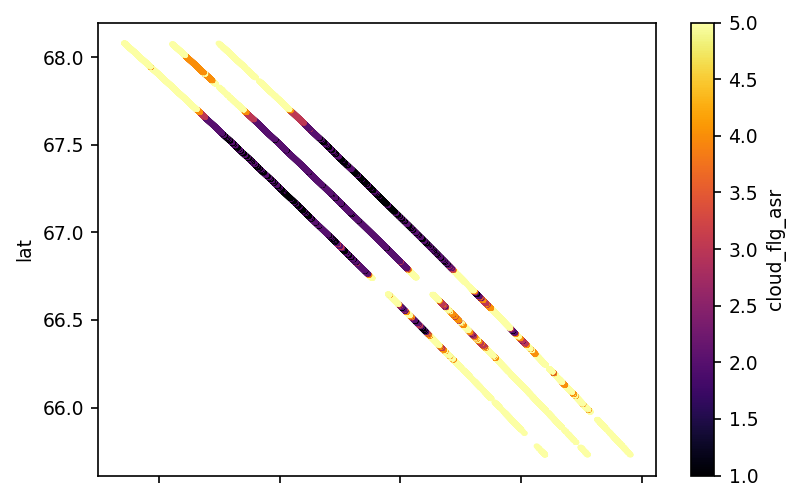

In [13]:
ax1 = atl6.loc[atl6['VIIRS_offset']<0].plot.scatter(x='lon', y='lat', c='Integer_Cloud_Mask', s = 2,  colormap='inferno_r')
ax2 = atl6.loc[atl6['VIIRS_offset']<0].plot.scatter(x='lon', y='lat', c='cloud_flg_asr', s = 2,  colormap='inferno')

ATL06 provides another cloud flag, `cloud_flg_atm`, which counts the number of layers found from the backscatter profile.
Something that would be interesting to understand is: what are the points that correspond to one or more layers and are located in a non-cloudy area? Blowing snow? Crevasses? See for example the light grey points in the eastern tracks.

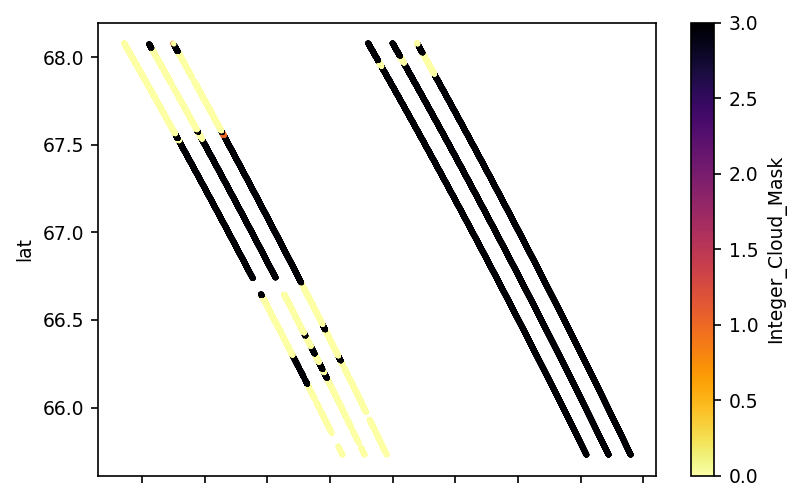

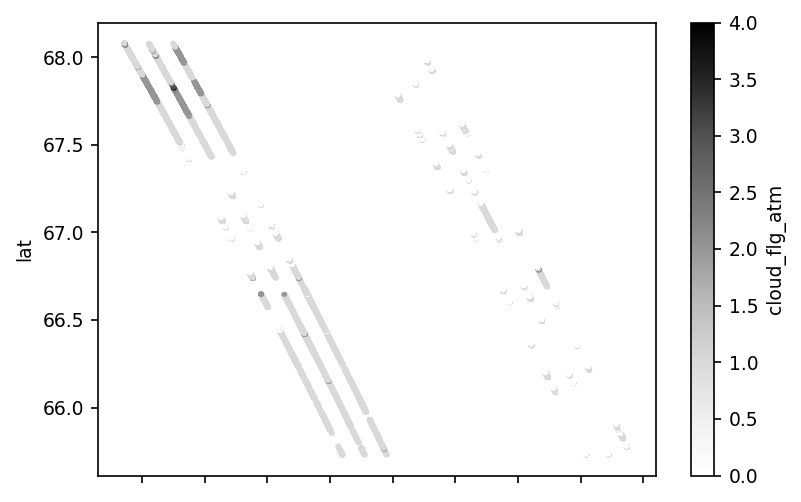

In [31]:
ax1 = atl6.plot.scatter(x='lon', y='lat', c='Integer_Cloud_Mask', s = 2,  colormap='inferno_r')
ax2 = atl6.plot.scatter(x='lon', y='lat', c='cloud_flg_atm', s = 2)

The `layer_flag` in ATL06 combines `cloud_flag_atm`, `cloud_flag_asr`, and `bsnow_con` to flag whether cloud or blowing snow are likely (value 1) or not (value 0). We can compare it with the `Integer_Cloud_Flag` derived from VIIRS. We can see that, ignoring some mismatch probably due to the time difference, the results are really similar.

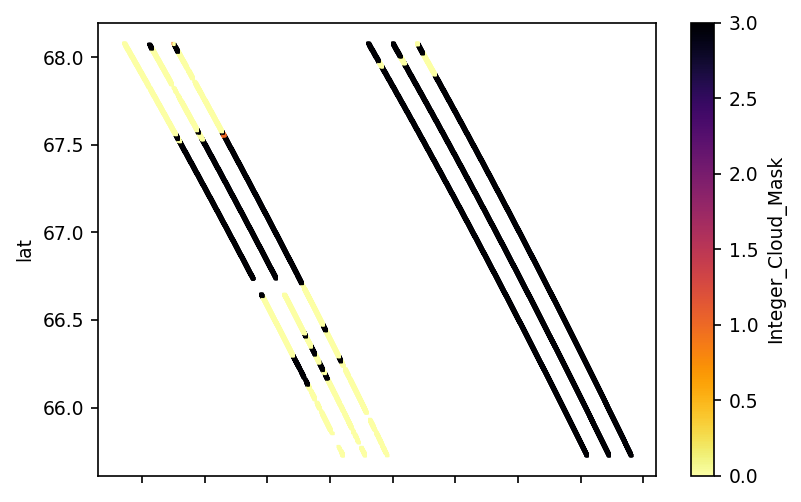

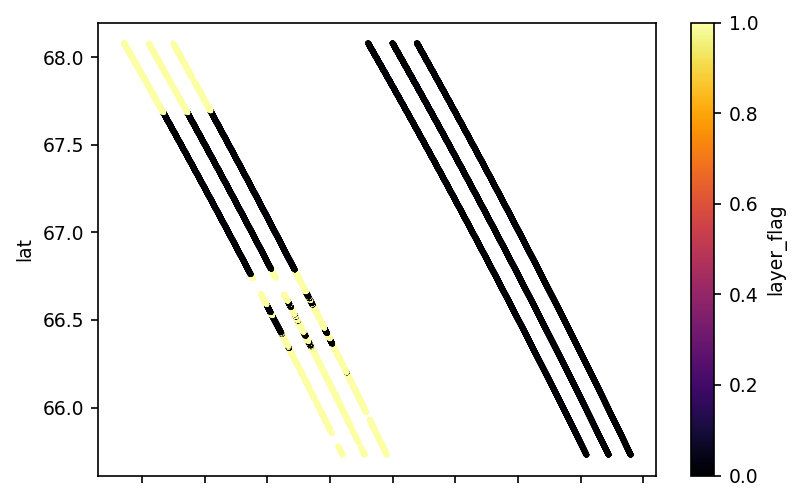

In [19]:
ax1 = atl6.plot.scatter(x='lon', y='lat' , marker='_', c='Integer_Cloud_Mask', s = 2,  colormap='inferno_r')
ax2 = atl6.plot.scatter(x='lon', y='lat', c='layer_flag', s = 2,  colormap= 'inferno')

The next plot highlights in yellow the areas where the `layer_flag` spots a cloud and the `Integer_Cloud_Mask` doesn't, and vice versa. We can see that most of such yellow points are in the areas where we conjectured a cloud movement over time. It would be interesting to check whether there are sparse yellow points in the dense violet areas. That would be unlikely due to cloud movement, but to incorrect classification of the `layer_flag`.

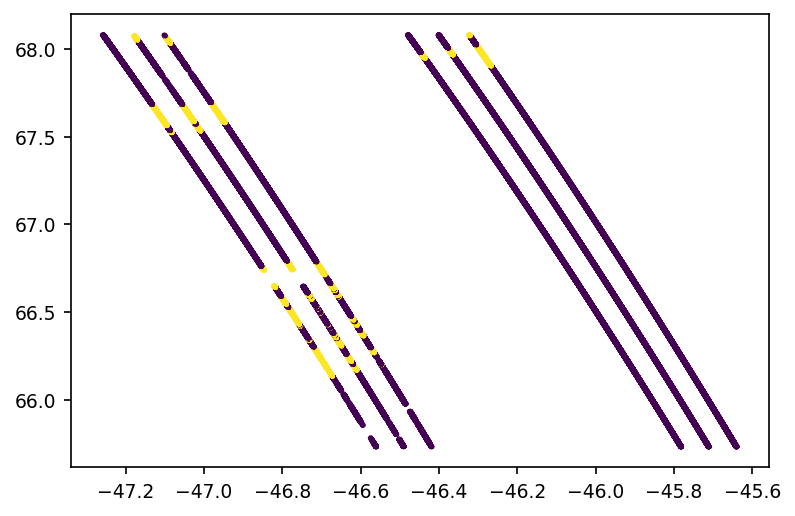

In [35]:
diff = (((atl6['Integer_Cloud_Mask']==0.0) & (atl6['layer_flag']!=1.0)) | ((atl6['Integer_Cloud_Mask']==3.0) & (atl6['layer_flag']!=0.0)))
plt.scatter(atl6.lon, atl6.lat, s=2, c=diff)

There are no yellow points in the eastern area with latitude lower than 67.6.

In [47]:
east = atl6.loc[atl6['VIIRS_offset']>0]
diff_east = (east['Integer_Cloud_Mask']==0.0) & (east['layer_flag']!=1.0) | ((east['Integer_Cloud_Mask']==3.0) & (east['layer_flag']!=0.0)) 
east.loc[diff_east & (east['lat']<67.6)]
#plt.scatter(east.lon, east.lat, s=2, c=diff_east, cmap='Greys')

,ground_track,t_year,lat,lon,Integer_Cloud_Mask,VIIRS_offset,h_li,s_li,q_flag,s_fg,...,cloud_flg_atm,msw_flag,fbsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,segment_id,w_surface_window_final
id,,,,,,,,,,,,,,,,,,,,,


Nothing anomalous is going on in the clear area at the center of the western area.

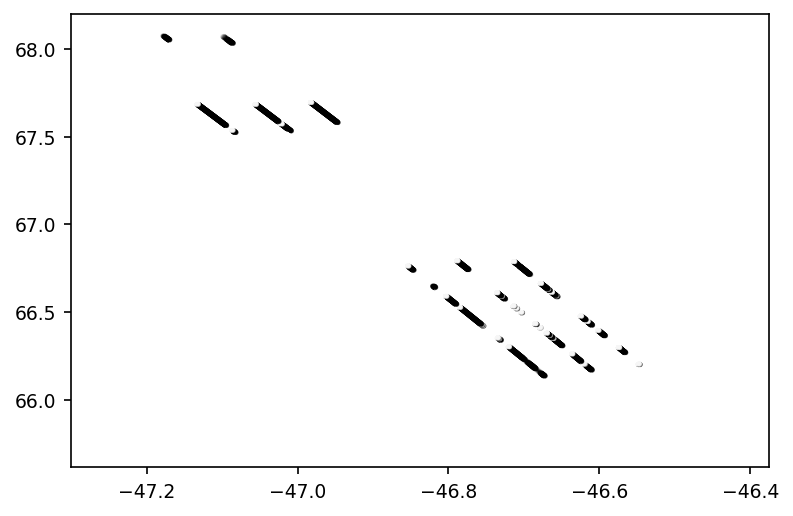

In [55]:
west = atl6.loc[atl6['VIIRS_offset']<0]
diff_west = (west['Integer_Cloud_Mask']==0.0) & (west['layer_flag']!=1.0) | ((west['Integer_Cloud_Mask']==3.0) & (west['layer_flag']!=0.0)) 
plt.scatter(west.lon, west.lat, s=2, c=diff_west, cmap='Greys',alpha=0.1)

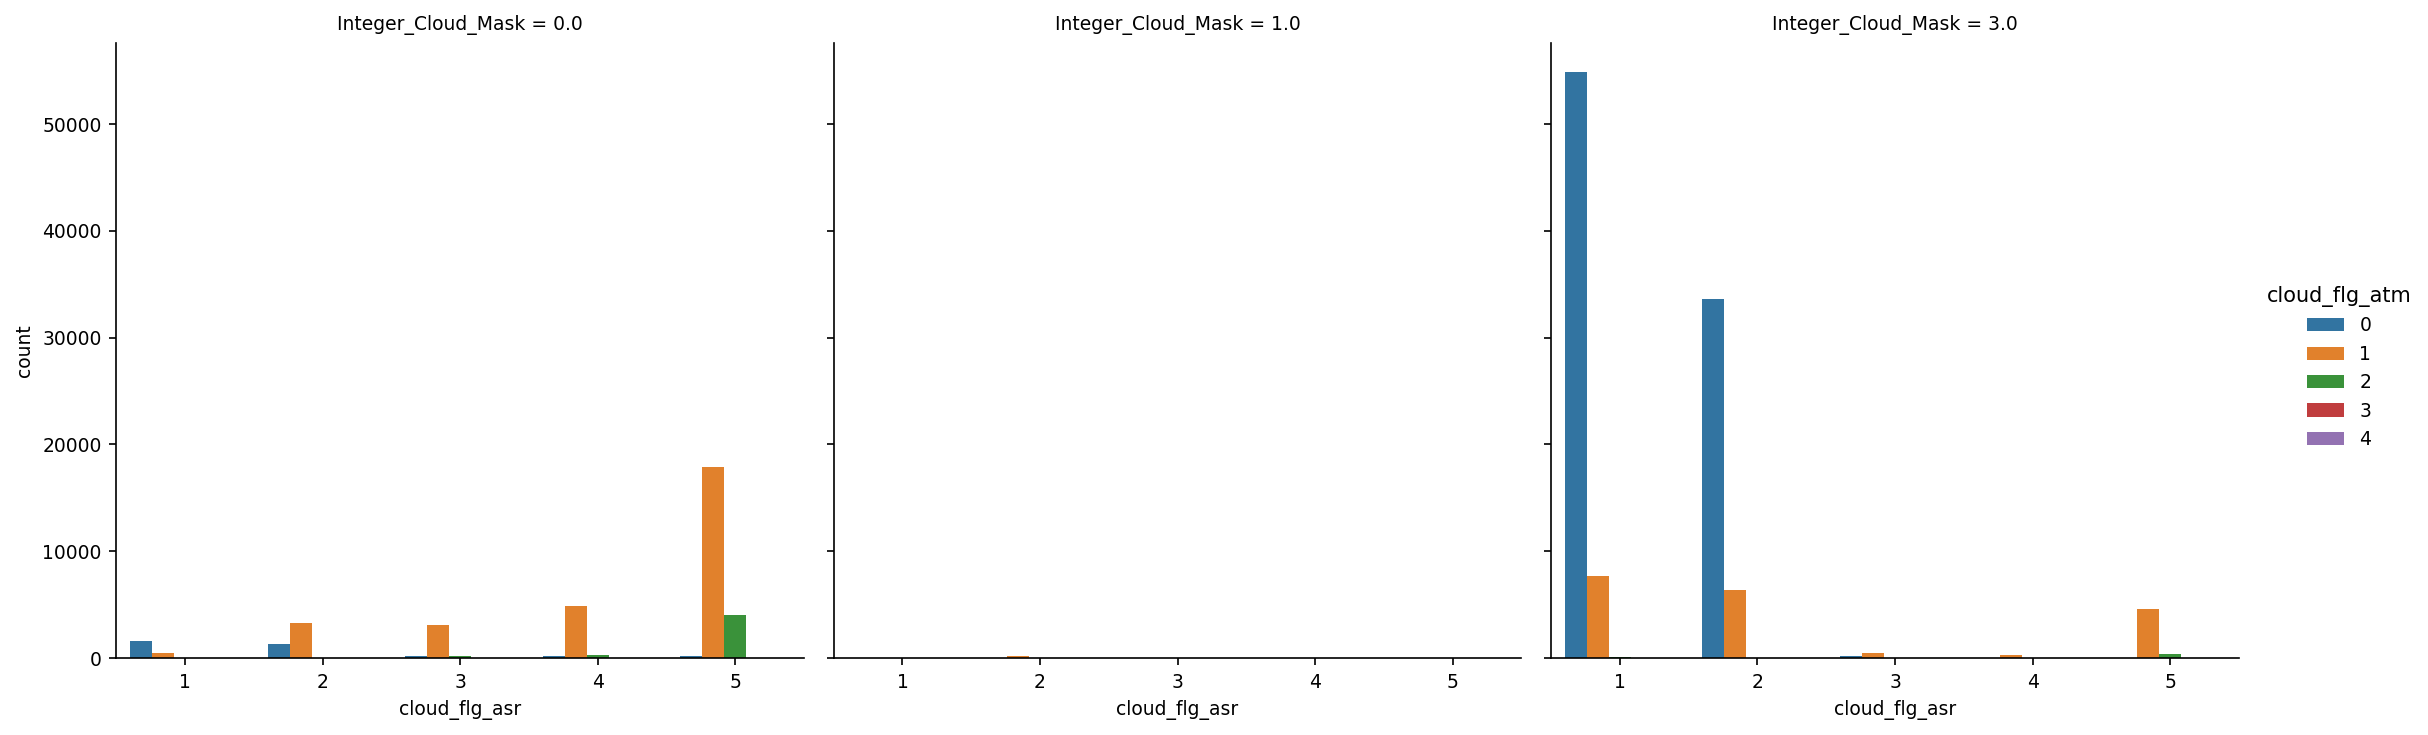

In [37]:
sns.catplot(x="cloud_flg_asr", hue="cloud_flg_atm", col="Integer_Cloud_Mask", kind="count", data=atl6)

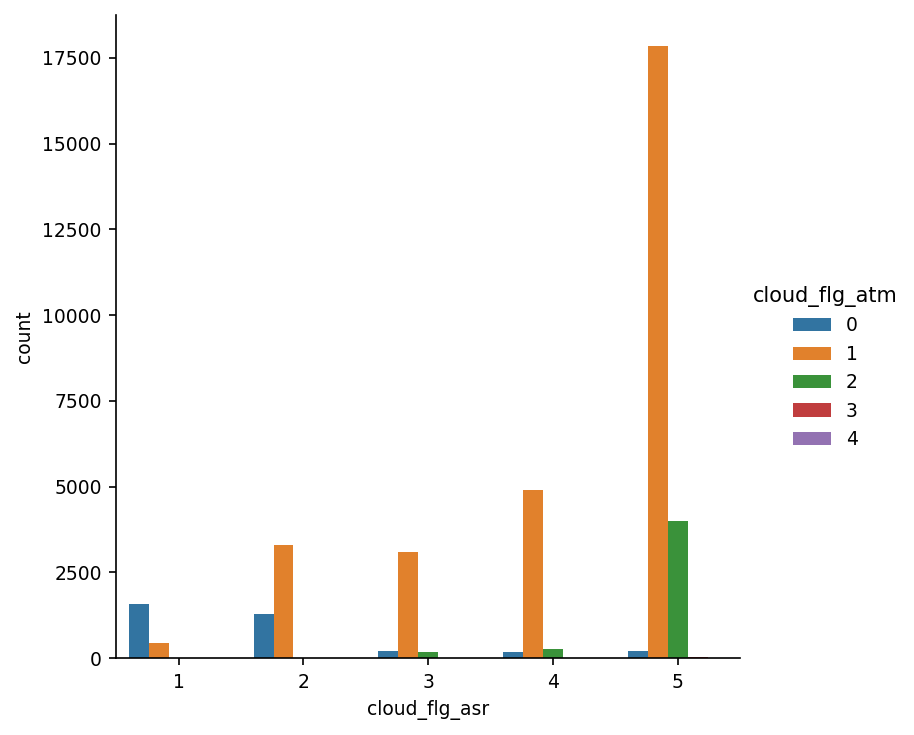

In [38]:
sns.catplot(data = atl6.loc[atl6['Integer_Cloud_Mask'] == 0.0], hue = 'cloud_flg_atm', x = 'cloud_flg_asr', kind ='count')

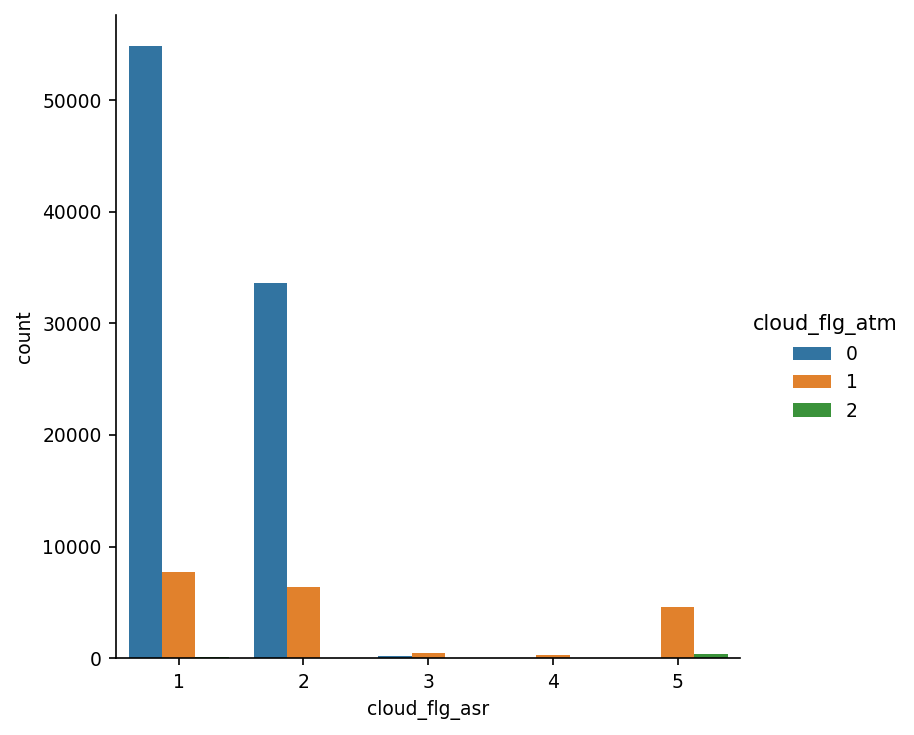

In [39]:
sns.catplot(data = atl6.loc[atl6['Integer_Cloud_Mask'] == 3.0], hue = 'cloud_flg_atm', x = 'cloud_flg_asr', kind ='count')

In [60]:
atl6.groupby(['Integer_Cloud_Mask','cloud_flg_atm']).size()

Integer_Cloud_Mask  cloud_flg_atm
0.0                 0                 3447
                    1                29589
                    2                 4433
                    3                   32
                    4                    2
1.0                 1                  192
3.0                 0                88672
                    1                19393
                    2                  491
dtype: int64

In [62]:
atl6.groupby(['cloud_flg_asr','cloud_flg_atm']).size()

cloud_flg_asr  cloud_flg_atm
1              0                56471
               1                 8108
               2                   88
2              0                34868
               1                 9810
               2                   28
3              0                  406
               1                 3586
               2                  204
4              0                  172
               1                 5218
               2                  254
5              0                  202
               1                22452
               2                 4350
               3                   32
               4                    2
dtype: int64

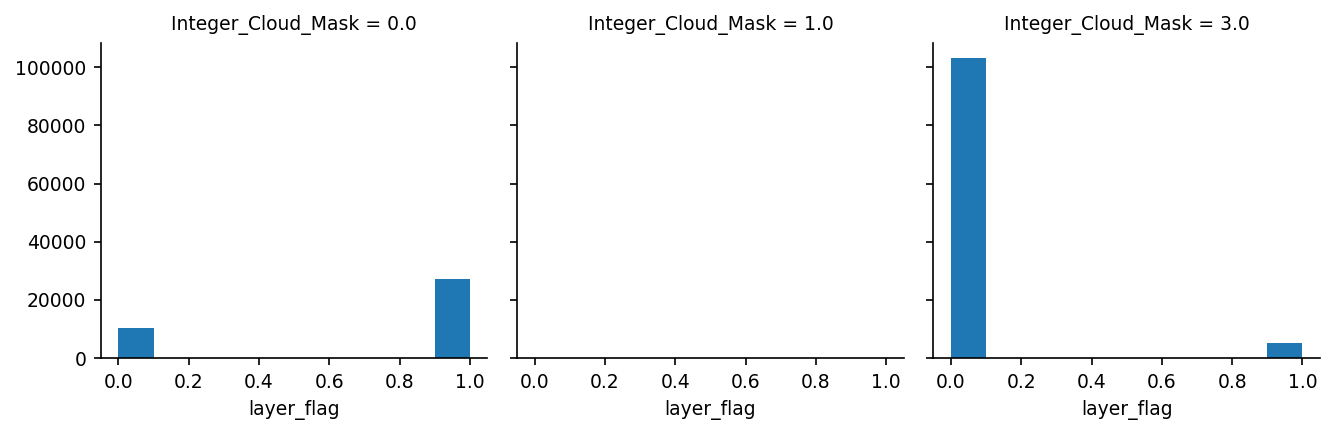

In [44]:
g = sns.FacetGrid(atl6, col="Integer_Cloud_Mask")
g.map(plt.hist, "layer_flag")

### 3) Other ATL06 flags

* __q_flag__: 0 corresponds to no quality issues, 1 to potential quality issues.

As we could expect, no area that is labeled as clear has quality issues, whereas some areas that have `layer_flag`=1 have potential quality issues.

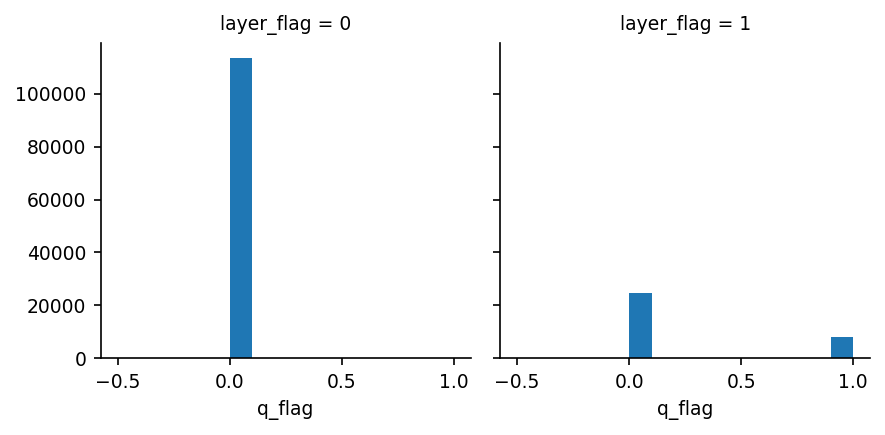

In [4]:
g = sns.FacetGrid(atl6, col="layer_flag")
g.map(plt.hist, "q_flag")

* __h_li__: land-ice segment height

We can see that there are outliers for which `h_li` is extremely high. We expect them to be data of poor quality.

In [32]:
atl6.groupby('layer_flag').h_li.mean()
atl6.h_li.describe()

count    1.462510e+05
mean     1.115886e+37
std      6.060254e+37
min      1.731312e+03
25%      1.940620e+03
50%      2.060112e+03
75%      2.189614e+03
max      3.402824e+38
Name: h_li, dtype: float64

No good quality data has `h_li` above 2.5e+03.

In [43]:
atl6.loc[(atl6['h_li']>2.5e+03) & (atl6['q_flag']<1)]

,ground_track,t_year,lat,lon,Integer_Cloud_Mask,VIIRS_offset,h_li,s_li,q_flag,s_fg,...,cloud_flg_atm,msw_flag,fbsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,segment_id,w_surface_window_final
id,,,,,,,,,,,,,,,,,,,,,


On the other hand, there are many low quality data that have `h_li` equal to 3.402824e+38.

In [54]:
print(atl6.loc[(atl6['h_li']>2.5e+03) & (atl6['q_flag']==1)].h_li.min(), atl6.loc[(atl6['h_li']>2.5e+03) & (atl6['q_flag']==1)].h_li.max())

3.4028235000000003e+38 3.4028235000000003e+38


In [80]:
s = np.shape(atl6.loc[ (atl6['h_li']>2.5e+03) & (atl6['q_flag']==1) ])[0] 
t = np.shape(atl6.loc[ atl6['q_flag']==1 ])[0]
print('A fraction of %f low quality data have extermely high h_li.' %(s/t))

A fraction of 0.605862 low quality data have extermely high h_li.


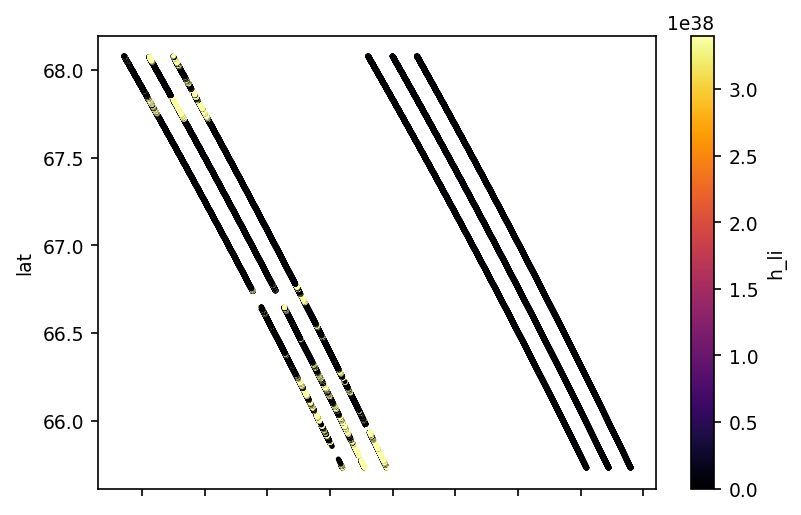

In [85]:
atl6.plot.scatter(x='lon', y='lat' , c='h_li', s = 2,  colormap='inferno')

## Possible idea

Use supervised learning to get a cloud classifier.
* Features: ATL06 flags + some feature from ATL03.
* Use images where there is a perfect temporal match between ATL06 and VIIRS in the training and validation part.

First steps:
* Find areas with perfect temporal match ATL06-VIIRS
    * Get time and lat/lon of ATL06 measurements on a large spatio-temporal scale. 
    * Query VIIRS dataset for those specific times and lat/lon and download data.
    * Get corresponding ATL06 data.
    